# About

This notebooks aims to compare `rtrgsyl` with scipy's solver against scipy's solver alone. 

# Benchmark

## Utils

In [2]:
from benchmark_utils import benchmark
from utils import solve_sylvester_scipy
from recursive import rtrgsyl

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Format the results of the benchmark() function
def format_results_bs(res_dic):
    df = pd.DataFrame(res_dic)
    df.time = df.time.apply(np.array)
    df['time_schur'] = df.time.apply(lambda lst: [tpl[0] for tpl in lst])
    df['time_solve'] = df.time.apply(lambda lst: [tpl[1] for tpl in lst])
    df['time_back'] = df.time.apply(lambda lst: [tpl[2] for tpl in lst])
    df.drop(columns='time', inplace=True)

    for e in df.columns:
        if e.startswith('time_'):
            df[f'{e}_mean'] = df[e].apply(np.mean)
            df[f'{e}_std'] = df[e].apply(np.std)
    
    df['m'] = df.dim.apply(lambda e: e[0])
    df['n'] = df.dim.apply(lambda e: e[1])
    
    return df

## Vary matrix sizes


In [5]:
blks=64
dimensions = [
    (250, 250), (500, 500), (1000, 1000), (1500, 1500)
]

In [10]:
res_rtrgsyl = benchmark(
    solve_fun=rtrgsyl,
    vary_param=('dim', dimensions),
    bertel_stewart=True,
    log_context={'solve_fun': 'rtrgsyl', 'std_solver': 'syl_scipy', 'bartel_stewart': True},
    blks=blks,
    std_solver=solve_sylvester_scipy
)

dim=(250, 250)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)


In [11]:
df_rtrgsyl = format_results_bs(res_rtrgsyl)
df_rtrgsyl.head(2)

,blks,std_solver,dim,solve_fun,bartel_stewart,time_schur,time_solve,time_back,time_schur_mean,time_schur_std,time_solve_mean,time_solve_std,time_back_mean,time_back_std,m,n
0,64,syl_scipy,"(250, 250)",rtrgsyl,True,"[0.13886809349060059, 0.13367414474487305, 0.0...","[0.05888485908508301, 0.04135870933532715, 0.0...","[0.0040302276611328125, 0.0006923675537109375,...",0.102607,0.028138,0.042878,0.012456,0.001484,0.001303,250,250
1,64,syl_scipy,"(500, 500)",rtrgsyl,True,"[0.32266950607299805, 0.35124731063842773, 0.3...","[0.13054299354553223, 0.12826824188232422, 0.1...","[0.0023572444915771484, 0.002206563949584961, ...",0.325519,0.016582,0.146018,0.018449,0.005175,0.004544,500,500


In [13]:
res_scipy = benchmark(
    solve_fun=solve_sylvester_scipy,
    vary_param=('dim', dimensions),
    bertel_stewart=True,
    log_context={'solve_fun': 'syl_scipy', 'bartel_stewart': True}
)

dim=(250, 250)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)


In [14]:
df_scipy = format_results_bs(res_scipy)
df_scipy.head(2)

,dim,solve_fun,bartel_stewart,time_schur,time_solve,time_back,time_schur_mean,time_schur_std,time_solve_mean,time_solve_std,time_back_mean,time_back_std,m,n
0,"(250, 250)",syl_scipy,True,"[0.19471383094787598, 0.08255720138549805, 0.0...","[0.14088749885559082, 0.07141494750976562, 0.0...","[0.0007369518280029297, 0.0006515979766845703,...",0.103349,0.045969,0.092354,0.026583,0.000700,0.000065,250,250
1,"(500, 500)",syl_scipy,True,"[0.39386773109436035, 0.3263556957244873, 0.34...","[0.346513032913208, 0.3581843376159668, 0.3316...","[0.0022292137145996094, 0.002212047576904297, ...",0.352437,0.025640,0.326555,0.024647,0.005962,0.006668,500,500


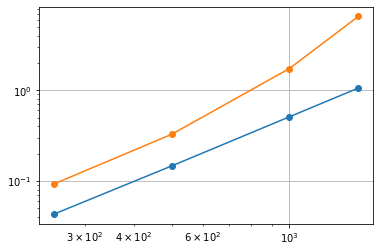

In [19]:
plt.loglog(df_rtrgsyl.n, df_rtrgsyl.time_solve_mean, '-o', label='rtrgsyl')
plt.loglog(df_scipy.n, df_scipy.time_solve_mean, '-o', label='rtrgsyl')
plt.grid()

## Save results

In [175]:
import json

res_dump = res_rtrgsyl + res_scipy

with open('res/benchmark_rtrgsyl.json', 'w') as f:
    json.dump(res_dump, f)

# Produce plots

In [22]:
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib()
import seaborn as sns
sns.set(style='whitegrid')

In [63]:
def plot_multiple_runs(df, x, y, ystd, label, color):
    plt.plot(df[x], df[y], '-o', label=label, color=color)
    plt.fill_between(df[x], df[y] - df[ystd], df[y] + df[ystd], alpha=.4, color=color)

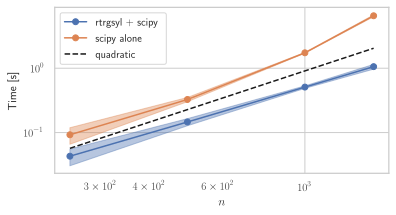

In [174]:
cols = sns.color_palette()

plt.figure(figsize=(6, 3))

plot_multiple_runs(df_rtrgsyl, 'n', 'time_solve_mean', 'time_solve_std', 'rtrgsyl + scipy', cols[0])
plot_multiple_runs(df_scipy, 'n', 'time_solve_mean', 'time_solve_std', 'scipy alone', cols[1])

point = np.array([df_rtrgsyl.n.min(), df_rtrgsyl.n.max()])
plt.loglog(point, point**2 / 1100000, '--k', label='quadratic')

plt.xlabel('$n$'); plt.ylabel('Time [s]')
plt.legend();
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, LogLocator)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.savefig('res/benchmark_retrgsyl_vs_scipy.pdf', bbox_inches='tight')

# Determine slopes

In [108]:
df = pd.concat((df_rtrgsyl, df_scipy)).reset_index(drop=True)[['n', 'time_solve_mean', 'solve_fun']]
df['logn'] = np.log(df.n)
df['logtime'] = np.log(df.time_solve_mean)
df.rename(columns={'solve_fun': 'fun'}, inplace=True)

df

,n,time_solve_mean,fun,logn,logtime
0,250,0.042878,rtrgsyl,5.521461,-3.149396
1,500,0.146018,rtrgsyl,6.214608,-1.924025
2,1000,0.509316,rtrgsyl,6.907755,-0.674688
3,1500,1.058538,rtrgsyl,7.313220,0.056889
4,250,0.092354,syl_scipy,5.521461,-2.382122
5,500,0.326555,syl_scipy,6.214608,-1.119157
6,1000,1.738717,syl_scipy,6.907755,0.553147
7,1500,6.545200,syl_scipy,7.313220,1.878732


In [110]:
from sklearn.linear_model import LinearRegression

In [121]:
regline_rtrgsyl = LinearRegression().fit(df.loc[df.fun == 'rtrgsyl', 'logn'].values.reshape(-1, 1), 
                                         df.loc[df.fun == 'rtrgsyl', 'logtime'].values.reshape(-1, 1))
regline_scipy   = LinearRegression().fit(df.loc[df.fun == 'syl_scipy', 'logn'].values.reshape(-1, 1), 
                                         df.loc[df.fun == 'syl_scipy', 'logtime'].values.reshape(-1, 1))

In [134]:
slope_rtrgsyl = regline_rtrgsyl.coef_[0, 0]
slope_scipy = regline_scipy.coef_[0, 0]

slope_rtrgsyl, slope_scipy

(1.7903196222103375, 2.3537022705480006)

In [120]:
regline_rtrgsyl.coef_

array([[1.79031962]])

In [128]:
regline_rtrgsyl.intercept_

array([-13.04065663])

Sanity check:

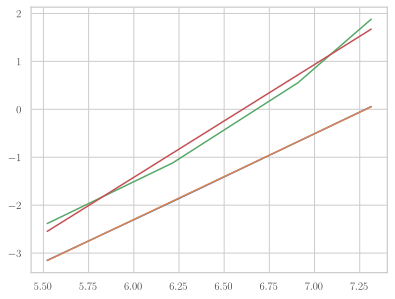

In [133]:
grid = np.linspace(min(df.logn), max(df.logn), 10)

plt.plot(df.loc[df.fun == 'rtrgsyl', 'logn'], df.loc[df.fun == 'rtrgsyl', 'logtime'])
plt.plot(grid, grid * slope_rtrgsyl + regline_rtrgsyl.intercept_)

plt.plot(df.loc[df.fun == 'syl_scipy', 'logn'], df.loc[df.fun == 'syl_scipy', 'logtime'])
plt.plot(grid, grid * slope_scipy + regline_scipy.intercept_)